The slab model is a key assumption in the current DEM. In this notebook I'm going to see if we can replace the slab model with something even more flexible to test that our results are robust. 

In [1]:
import numpy as np 
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
# randomly sample the inclinatiion angle from 0 - pi/2 
incl = np.random.uniform(0., 0.5*np.pi, size=int(1e4))
sec_incl = 1./np.cos(incl) 

#Eq. 14 of Somerville+(1999) 
slab_AV = lambda tauV: -2.5 * np.log10((1.0 - np.exp(-tauV * sec_incl)) / (tauV * sec_incl)) 

(0.0, 7.5)

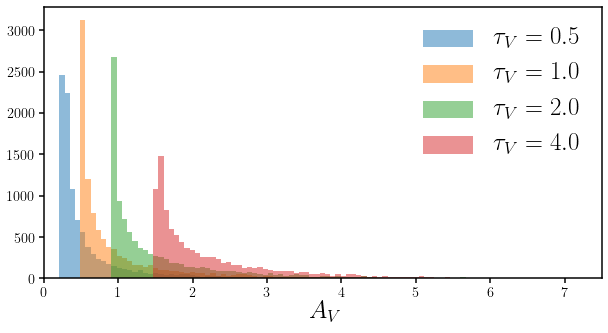

In [3]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for tau in [0.5, 1., 2., 4.]: 
    _ = sub.hist(slab_AV(tau), range=(0., 7), bins=100, alpha=0.5, label=r'$\tau_V = %.1f$' % tau)
sub.legend(loc='upper right', fontsize=25)
sub.set_xlabel('$A_V$', fontsize=25)
sub.set_xlim(0., 7.5)

In comparison here's some $A_V$ values derived from observations: **Brinchmann+(2004), Salim+(2018) and Salim & Narayanan (2020)**

In [4]:
from IPython.display import Image

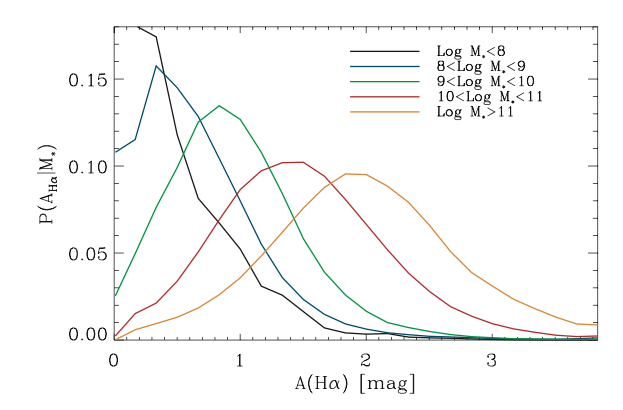

In [5]:
Image(filename='/Users/ChangHoon/Pictures/screenshots/brinchmann_etal_2004.png')

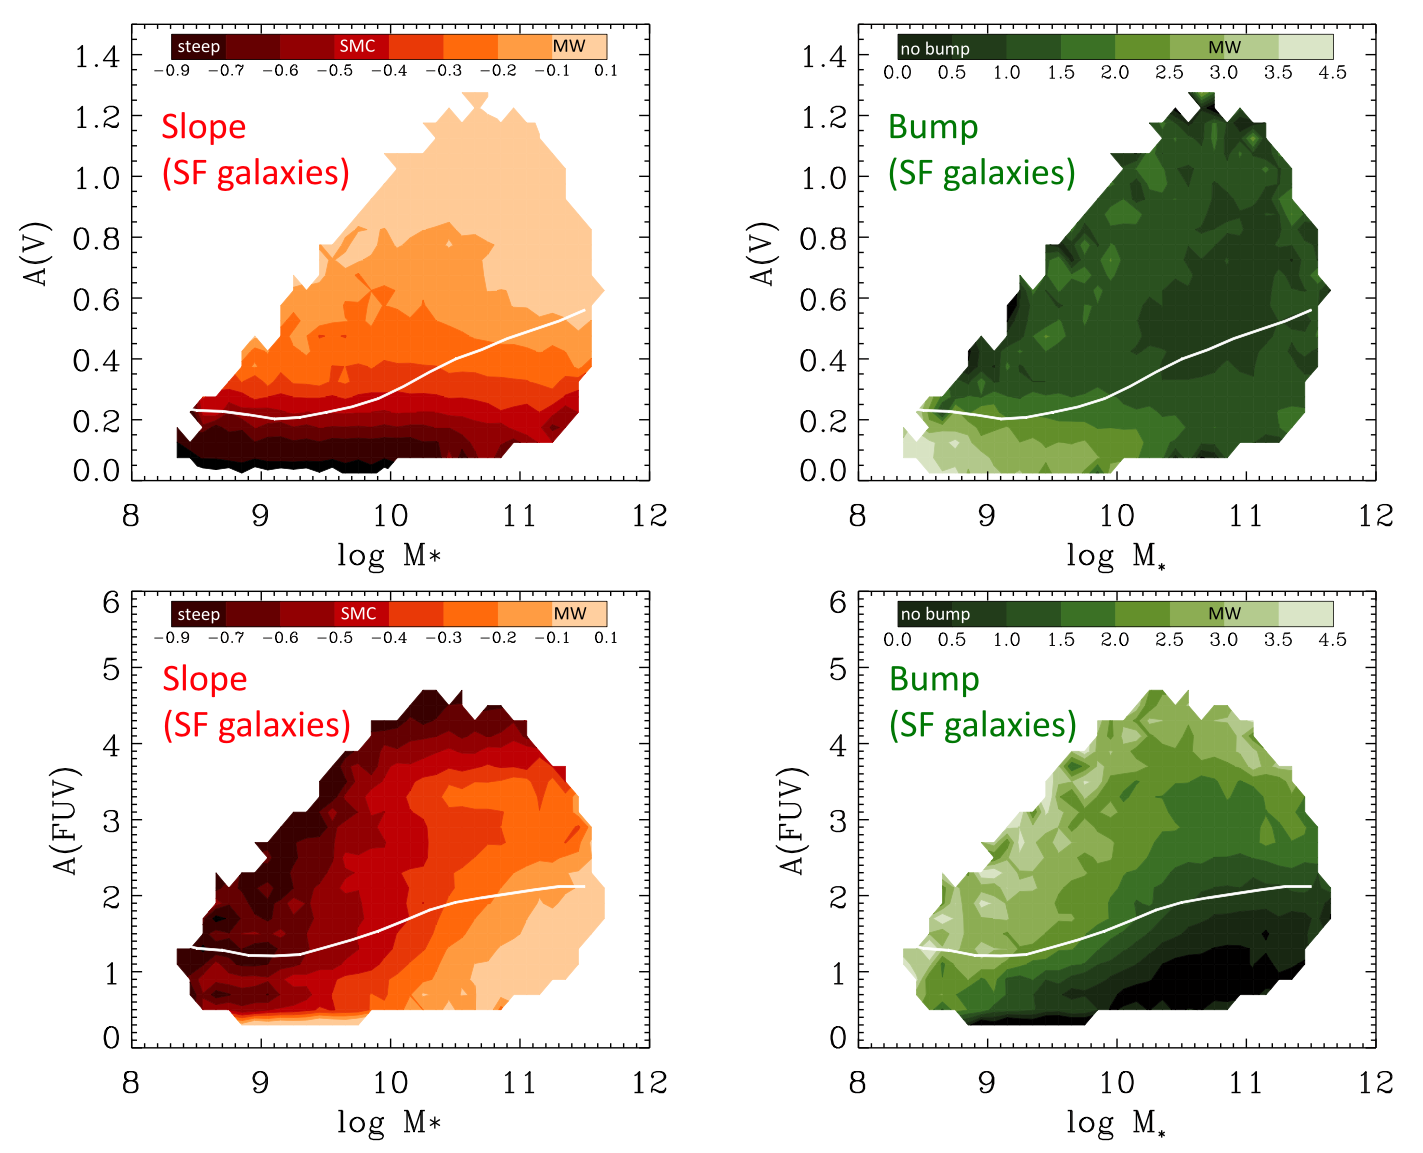

In [6]:
Image(filename='/Users/ChangHoon/Pictures/screenshots/salim_etal_2018.png')

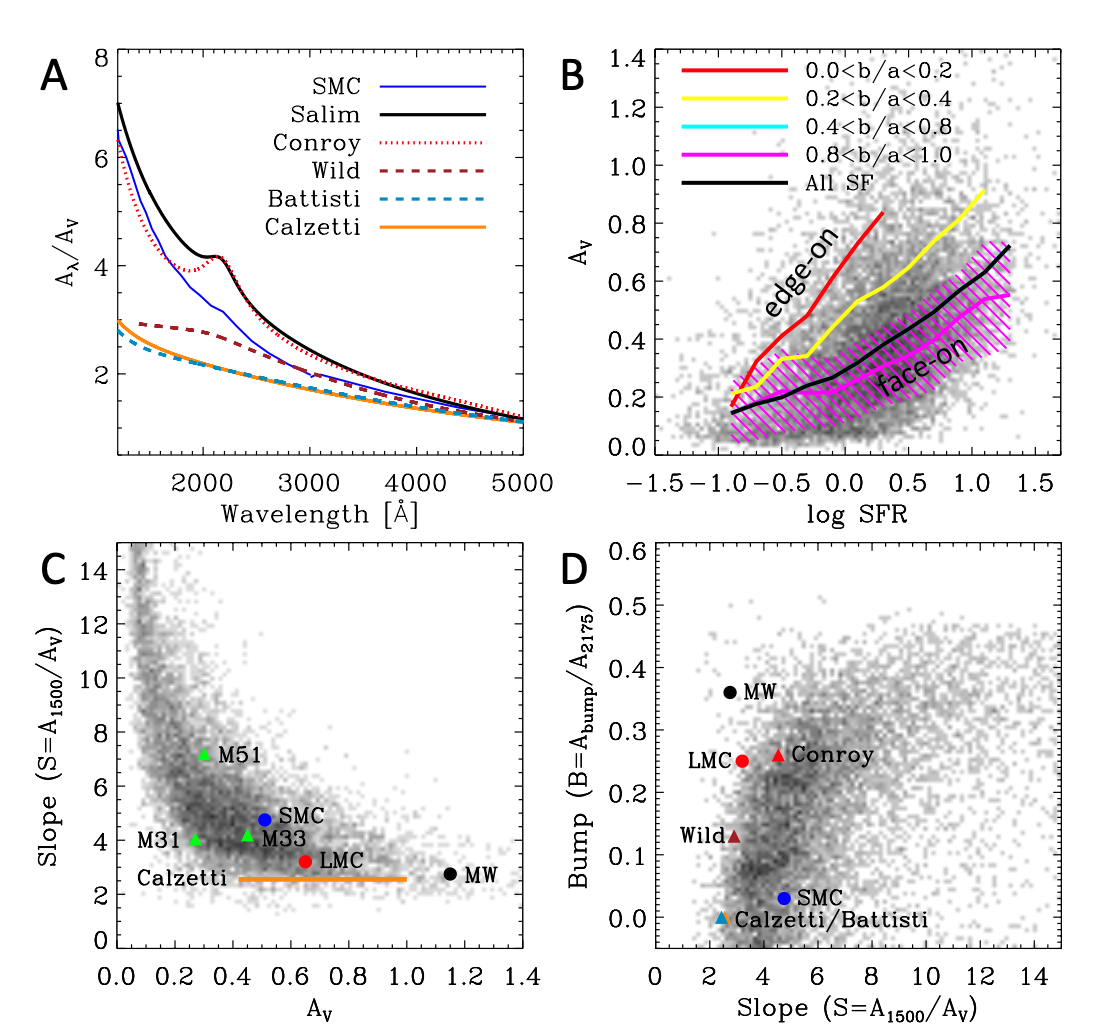

In [7]:
Image(filename='/Users/ChangHoon/Pictures/screenshots/salim_narayanan_2020.png')

$A_V$ measurements for SDSS galaxies where $\tau_V$ is derived from continuum fits seem close neough to a Gaussian...

In [8]:
Image(url="https://user-images.githubusercontent.com/7421403/79980434-b49ee980-8468-11ea-9c09-9e1a6f430649.png")

Lets try a **truncated normal distribution** as a slab model replacement

$$A_V \sim \mathcal{N}_{T}(\mu_{A_V}, \sigma_{A_V})$$

where now instead of being parameterized via $\tau_V$ and the slab model, we have 
$\mu_{A_V}$ and $\sigma_{A_V}$, which define the mean and variance of a truncted
normal diistribution.

Similar to our linear parameterization, we can set $\mu_{A_V}$ and $\sigma_{A_V}$ 
to be linear models w.r.t. $M_*$ and SFR. 

In [9]:
from scipy.stats import truncnorm

Av_sf = truncnorm.rvs(-1., np.inf, loc=1., scale=1., size=10000)
Av_q = truncnorm.rvs(-1., np.inf, loc=0.5, scale=0.5, size=10000)

(-0.2, 7.5)

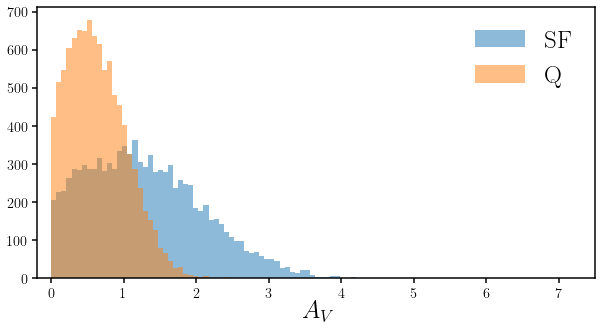

In [10]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

_ = sub.hist(Av_sf, range=(0., 7), bins=100, alpha=0.5, color='C0', label=r'SF')
_ = sub.hist(Av_q, range=(0., 7), bins=100, alpha=0.5, color='C1', label=r'Q')
sub.legend(loc='upper right', fontsize=25)
sub.set_xlabel('$A_V$', fontsize=25)
sub.set_xlim(-0.2, 7.5)

## now lets test the `dustfm` implementation of the truncated normal DEM

In [11]:
from galpopfm import dustfm as dustFM

In [12]:
T_lam_sf = [dustFM.DEM_tnorm_noll_msfr(np.array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]), 
                           np.linspace(3e3, 1e4, 7000), 
                           np.ones(7000), 
                           10., 
                           0., 
                           nebular=False) for i in range(10000)]
A_lam_sf = np.log10(T_lam_sf)/-0.4

T_lam_q = [dustFM.DEM_tnorm_noll_msfr(np.array([0., 0., 0.5, 0., 0., 0.5, 0., 0., 0., 0., 0., 1.]), 
                           np.linspace(3e3, 1e4, 7000), 
                           np.ones(7000), 
                           10., 
                           0., 
                           nebular=False) for i in range(10000)]
A_lam_q = np.log10(T_lam_q)/-0.4

(-0.2, 7.5)

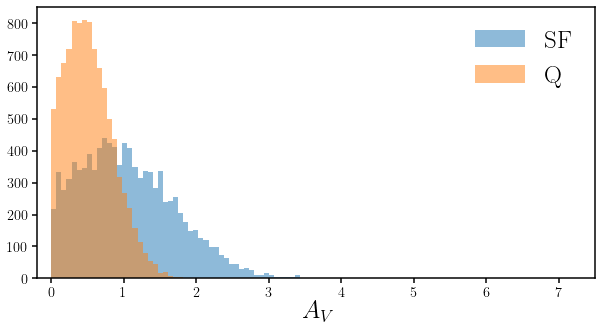

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)

_ = sub.hist(np.array(A_lam_sf[:,2500]), range=(0., 7), bins=100, alpha=0.5, color='C0', label=r'SF')
_ = sub.hist(np.array(A_lam_q[:,2500]), range=(0., 7), bins=100, alpha=0.5, color='C1', label=r'Q')
sub.legend(loc='upper right', fontsize=25)
sub.set_xlabel('$A_V$', fontsize=25)
sub.set_xlim(-0.2, 7.5)